In [1]:
import cv2
import numpy as np
import glob
import math
from matplotlib import pyplot as plt

In [2]:
SIFT_method = True

Questa funzione prende in ingresso l'immagine originale, l'immagine ritagliata e il nome del salvataggio. Restituisce un immagine che rappresenta la zona di lavoro

In [3]:
keypoints_fixed = []
x1 = 60
y1 = 60

x2 = 80
y2 = 40

x3 = 40
y3 = 40

x4 = 40
y4= 80

x5 = 80
y5 = 80

size = 75

angle = 0

square_size =120
for i in range (1):
    # rappresenta X, Y, size diametro, angle, response, octave, class id
    keypoints_fixed.append(cv2.KeyPoint(x1,y1+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x2,y2+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x3,y3+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x4,y4+i*square_size,size, angle, 0, 0, -1 ))
    keypoints_fixed.append(cv2.KeyPoint(x5,y5+i*square_size,size, angle, 0, 0, -1 ))




In [4]:
def cutWorkSpace(img,border): 
    # dimensioni immagini
    img_h = 2048
    img_l = 2048
    # offset per posizionamento su area d'indagine
    offset_x = 600
    offset_y = 500
    
    #taglio per garantire la ricerca sull'area di interesse, evitando rumori dati dallo sfondo
    crop_img = img[offset_y:img_h-offset_y, offset_x:img_l-offset_x]
    
    # Convert the img to grayscale
    gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    high_thresh, thresh_im = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    #cv2.imwrite('provaT.jpg', thresh_im)
    lowThresh = 0.5*high_thresh
    
    
    # Apply edge detection method on the image
    #edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    edges = cv2.Canny(blurred,20,150,apertureSize = 3)
    #cv2.imwrite('results_img/'+str(count_img)+'ed.jpg', edges)
    #cv2.imwrite('canny.jpg', edges)
    # This returns an array of r and theta values
    lines = cv2.HoughLines(edges,1,np.pi/180, 100)
    #cv2.imwrite('Risultati/resFS'+name+'c.jpg', edges)
    # The below for loop runs till r and theta values 
    # are in the range of the 2d array
    i = 0
    x_first = 0
    x_second = 0
    count = 0
    delta = 30
    thetaFinal = 0
    while count < 2:
        for r,theta in lines[i]:
            # Stores the value of cos(theta) in a
            a = np.cos(theta)

            # Stores the value of sin(theta) in b
            b = np.sin(theta)

            # x0 stores the value rcos(theta)
            x0 = a*r

            # y0 stores the value rsin(theta)
            y0 = b*r

            #ti define line lenght
            const = 3000
            # x1 stores the rounded off value of (rcos(theta)-1000sin(theta))
            x1 = int(x0 + const*(-b))

            # y1 stores the rounded off value of (rsin(theta)+1000cos(theta))
            y1 = int(y0 + const*(a))

            # x2 stores the rounded off value of (rcos(theta)+1000sin(theta))
            x2 = int(x0 - const*(-b))

            # y2 stores the rounded off value of (rsin(theta)-1000cos(theta))
            y2 = int(y0 - const*(a))

            if count == 0 :
                if theta != 0:
                    thetaFinal = 180-math.degrees(theta)
                x_first = x0
                #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                count += 1
            else:
                if abs(x_first-x0) > delta :
                    x_second = x0
                    #cv2.line(img,(x1+offset_x,y1+offset_y), (x2+offset_x,y2+offset_y), (0,0,255),2)
                    count += 1
            i += 1
    # All the changes made in the input image are finally
    # written on a new image houghlines.jpg
    #cv2.imwrite('Risultati/res'+name+'.jpg', img)
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # rotate our image by Theta degrees around the center of the image
    M = cv2.getRotationMatrix2D((cX, cY), -thetaFinal, 1.0)
    rotated = cv2.warpAffine(img, M, (w, h))
    scale_percent = 100 # percent of original size

  
    if x_first < x_second:
        
        median = (x_second+x_first)//2
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)        
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    else:
        median = (x_first+x_second)//2.
        temp = rotated[0:img_h-1, int(offset_x+median-border):int(offset_x+median+border)]        
        #blurred = cv2.GaussianBlur(temp, (3,3), 0)
        width = int(temp.shape[1] * scale_percent / 100)
        height = int(temp.shape[0] * scale_percent / 100)
        dim = (width, height)
        temp = cv2.resize(temp, dim, interpolation = cv2.INTER_AREA)
        gray = cv2.cvtColor(temp,cv2.COLOR_BGR2GRAY)
        return  gray
    

In [5]:
def divideImage(img,pcs):
    results = []
    lung = len(img) // pcs
    for i in range(pcs):
        results.append(img[(lung*i):(lung*(i+1)-1)][:])

    return results

## Creazione histogramma usando features - creazione NN
accetta in ingresso un vettore con [[img],[classe]]
in uscita mi ritorna kmeans e MLP

In [6]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.neural_network import MLPClassifier

def createNN(imgsWithClass, Nclusters):
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()
    else:
        orb = cv2.ORB_create()   
    results = imgsWithClass[0]

    keypoints = []
    descriptors = []
    dico = []
    for img in results:
        if SIFT_method:
            #keypoints_temp = keypoints_fixed
            #keypoints_temp, descriptors_temp = sift.compute(img, keypoints_temp)
            keypoints_temp,descriptors_temp = sift.detectAndCompute(img,None)
        else:    
            keypoints_temp, descriptors_temp = orb.detectAndCompute(img, None)
        if len(keypoints_temp) == 0:
            print('trovato nulla')
            plt.imshow(img)
            plt.show()
            keypoints_temp = keypoints_fixed
            keypoints_temp, descriptors_temp = sift.compute(img, keypoints_temp)
            keypoints.append(keypoints_temp)
            descriptors.append(descriptors_temp)
        for d in descriptors_temp:
            dico.append(d)        
    k = Nclusters
    batch_size = 256*4
    kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, verbose=1).fit(dico)
    
    length = len(results)

    train_index = length - 1 
    train_imgs = results[:train_index]
    validation_imgs = results[train_index:]
    
    # creo histogramma con valori trovati di feature per ogni immagine di train
    kmeans.verbose = False
    histo_list = []

    for img in train_imgs:
        if SIFT_method:
            #kp = keypoints_fixed
            #kp, des = sift.compute(img, kp)
            kp,des = sift.detectAndCompute(img,None)
        else:
            kp, des = orb.detectAndCompute(img,None)
            
        if len(kp) == 0:
            print('trovato nulla')
            plt.imshow(img)
            plt.show()
            kp = keypoints_fixed
            kp, des = sift.compute(img, kp)
            
        histo = np.zeros(k)
        nkp = np.size(kp)

        for d in des:
            idx = kmeans.predict([d])
            histo[idx] += 1/nkp # Because we need normalized histograms, I prefere to add 1/nkp directly

        histo_list.append(histo)
    #creo X_train e Y_train
    X_train = np.array(histo_list) 
    print(len(X_train))
    Y_train = imgsWithClass[1][:train_index]
    mlp = MLPClassifier(verbose=True, max_iter=600000,hidden_layer_sizes=1000, alpha=0.0001, n_iter_no_change=10)
    mlp.fit(X_train, Y_train)
    
    Y_val = imgsWithClass[1][train_index:]
    val_result = []
    i = 0 
    for img in validation_imgs:
        if SIFT_method:
            #kp = keypoints_fixed
            #kp, des = sift.compute(img, kp)
            kp,des = sift.detectAndCompute(img,None)
            
        else:
            kp, des = orb.detectAndCompute(img,None)
        x = np.zeros(k)
        nkp = np.size(kp)
        for d in des:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp #ottengo vettore normalizzato da kmeans
        res = mlp.predict_proba([x])
        row = []
        # predico. salvo probabilità classificazione e unisco risultato vero per verifica
        for e in res[0]:
            row.append(e)
        if row[0] < row[1]:
            val_result.append([row,Y_val[i],"Scarto"])
        else:
            val_result.append([row,Y_val[i]])
        i += 1
    
    return kmeans, mlp, val_result

Creo funzione per testare immagini sulla NN trovata

In [7]:
def testNN(img_test,border,pcs,Nclusters):
    img = cutWorkSpace(img_test,border)
    imgs = divideImage(img,pcs)
    if SIFT_method:
        sift = cv2.xfeatures2d.SIFT_create()
    else:
        orb = cv2.ORB_create()   

    k = Nclusters
    results = []
    for img in imgs:
        if SIFT_method:
            #kp = keypoints_fixed
            #kp, des = sift.compute(img, kp)
            kp,des = sift.detectAndCompute(img,None)
            
        else:
            kp, des = orb.detectAndCompute(img,None)
        x = np.zeros(k)
        nkp = np.size(kp)
        for d in des:
            idx = kmeans.predict([d])
            x[idx] += 1/nkp #ottengo vettore normalizzato da kmeans
        results.append(mlp.predict_proba([x])[0])

        
    return results

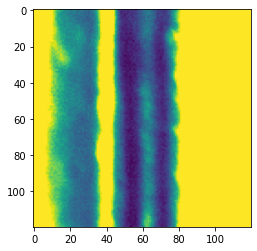

In [8]:
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70/*.tif'
pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100/*.tif'
#pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120/*.tif'

pathFS = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScarti/*.tif'
pathScarti = '/Users/leonardoaggio/Desktop/Dataset/S606C/Scarti/*.tif'

pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni70Val/*.tif'
pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni100Val/*.tif'
#pathBuoniVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/Buoni120Val/*.tif'

pathFSVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/FalsiScartiVal/*.tif'
pathScartiVal = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiVal/*.tif'

pezziXimmagine = 17
border = 60
Nclusters = 50

results = []
img_results = []
list_paths = []

temp = '/Users/leonardoaggio/Desktop/Dataset/Dataset/SectionScarti/*.tif'

pathBuoni = '/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v1/*.tif'


list_paths_scarti = glob.glob(temp)
results += [1] * len(glob.glob(temp))

list_paths = glob.glob(pathBuoni) 
results += [0] * len(glob.glob(pathBuoni)) * pezziXimmagine

#list_paths += glob.glob(pathFS)
#results += [0] * len(glob.glob(pathFS)) * pezziXimmagine


#list_paths += glob.glob(pathBuoniVal) 
#results += [0] * len(glob.glob(pathBuoniVal)) * pezziXimmagine

#list_paths += glob.glob(pathFSVal)
#results += [0] * len(glob.glob(pathFSVal)) * pezziXimmagine

#list_paths += glob.glob(pathScartiVal)
#results += [1] * len(glob.glob(pathScartiVal)) * pezziXimmagine


for img_path in list_paths_scarti:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #plt.imshow(img)
    #plt.show()
    img_results.append(img)

#print(results)
i = 0
for img_path in list_paths:
    img = cv2.imread(img_path)
    temp = cutWorkSpace(img,border)
    #cv2.imwrite('ImgScarte/img'+str(i)+'.jpg', temp)
    temp2 = divideImage(temp,pezziXimmagine)
    img_results += temp2
    j = 0
    for im in temp2:
        #cv2.imwrite('ImgScarte/img'+str(i)+'pzs'+str(j)+'.jpg', im)
        j += 1
    i += 1


list_paths = list_paths_scarti + list_paths      

#####
# ORA HO IMG_RESULTS & RESULTS
plt.imshow(img_results[10])
plt.show()

trovato nulla


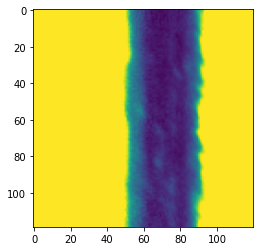

trovato nulla


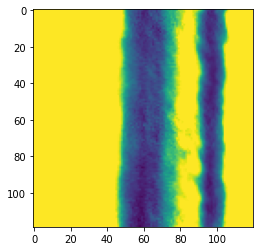

Init 1/3 with method: k-means++
Inertia for init 1/3: 152470995.753139
Init 2/3 with method: k-means++
Inertia for init 2/3: 156504033.787712
Init 3/3 with method: k-means++
Inertia for init 3/3: 154232665.226434
Minibatch iteration 1/19700: mean batch inertia: 51586.697735, ewa inertia: 51586.697735 
Minibatch iteration 2/19700: mean batch inertia: 49251.837692, ewa inertia: 51562.898128 
Minibatch iteration 3/19700: mean batch inertia: 49756.297635, ewa inertia: 51544.483156 
Minibatch iteration 4/19700: mean batch inertia: 50406.716996, ewa inertia: 51532.885720 
Minibatch iteration 5/19700: mean batch inertia: 48499.120786, ewa inertia: 51501.962062 
Minibatch iteration 6/19700: mean batch inertia: 49291.609104, ewa inertia: 51479.431575 
Minibatch iteration 7/19700: mean batch inertia: 49447.850000, ewa inertia: 51458.723334 
Minibatch iteration 8/19700: mean batch inertia: 49147.459226, ewa inertia: 51435.164243 
Minibatch iteration 9/19700: mean batch inertia: 48163.916388, ewa 

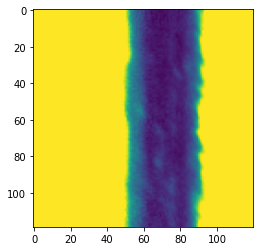

trovato nulla


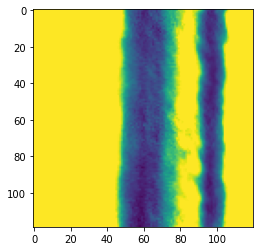

7496
Iteration 1, loss = 0.31166656
Iteration 2, loss = 0.06863675
Iteration 3, loss = 0.05837082
Iteration 4, loss = 0.05526048
Iteration 5, loss = 0.05203984
Iteration 6, loss = 0.04882639
Iteration 7, loss = 0.04589082
Iteration 8, loss = 0.04337248
Iteration 9, loss = 0.04113533
Iteration 10, loss = 0.03947486
Iteration 11, loss = 0.03770672
Iteration 12, loss = 0.03650284
Iteration 13, loss = 0.03538706
Iteration 14, loss = 0.03458376
Iteration 15, loss = 0.03396462
Iteration 16, loss = 0.03341750
Iteration 17, loss = 0.03281657
Iteration 18, loss = 0.03245957
Iteration 19, loss = 0.03197666
Iteration 20, loss = 0.03152150
Iteration 21, loss = 0.03121371
Iteration 22, loss = 0.03102189
Iteration 23, loss = 0.03081871
Iteration 24, loss = 0.03045076
Iteration 25, loss = 0.03025311
Iteration 26, loss = 0.02999671
Iteration 27, loss = 0.02972557
Iteration 28, loss = 0.02960426
Iteration 29, loss = 0.02935950
Iteration 30, loss = 0.02903794
Iteration 31, loss = 0.02894286
Iteration 32

In [9]:
imgsWithClass = [img_results,results]


kmeans, mlp, val_result = createNN(imgsWithClass, Nclusters)

In [10]:
for res in val_result:
    print(res)

[[0.9998644525963113, 0.00013554740368871396], 0]


In [11]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = pathScarti
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    try:
        res = testNN(img,border,pezziXimmagine,Nclusters)
        #print(res)
        # 1 se orb, 2 se sift
        if len(res) == 1:
           # print(res[0][0])
           # print(res[0][1])
            if res[0][0] > res [0][1]:
                print(res[0][0])
                print(res[0][1])
                i += 1
        else:
            j = 0
            for count in range(len(res)):
                #print(res[count][0])
                print(res[count])
                if res[count][0] > res [count][1]:
                    j += 1
            if j == len(res) :
                i+=1
                print('ciao')
    except:
        print('errore nell elaborazione')
print('TRAIN')
print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

[0.99698567 0.00301433]
[9.99582443e-01 4.17557193e-04]
[9.99857493e-01 1.42507319e-04]
[9.99907079e-01 9.29212063e-05]
[9.99998737e-01 1.26346130e-06]
[9.99644136e-01 3.55863934e-04]
[9.99999904e-01 9.55697668e-08]
[0.97807603 0.02192397]
[9.99863037e-01 1.36963256e-04]
[9.99920517e-01 7.94827914e-05]
[0.83019002 0.16980998]
[9.99960254e-01 3.97459468e-05]
[9.99995077e-01 4.92278626e-06]
[0.99325269 0.00674731]
[0.99847262 0.00152738]
[0.99882668 0.00117332]
[9.99628162e-01 3.71837968e-04]
ciao
[0.10581731 0.89418269]
[0.81239657 0.18760343]
[0.9756832 0.0243168]
[0.06036968 0.93963032]
[0.45221436 0.54778564]
[0.00977429 0.99022571]
[0.00567985 0.99432015]
[0.9974949 0.0025051]
[0.00292803 0.99707197]
[9.99994993e-01 5.00722742e-06]
[3.4710222e-05 9.9996529e-01]
[0.74746148 0.25253852]
[0.00476902 0.99523098]
[9.99999888e-01 1.11706184e-07]
[9.99997264e-01 2.73563618e-06]
[9.99288505e-01 7.11495396e-04]
[9.99999999e-01 1.26597987e-09]
[1.0000000e+00 1.0105524e-10]
[9.99988527e-01 1.1

In [12]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/ScartiTotali/*.tif'
temp = pathScartiVal
i = 0
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
   # plt.imshow(img)
    #plt.show()
    try:
        res = testNN(img,border,pezziXimmagine,Nclusters)
        #print(res)
        # 1 se orb, 2 se sift
        if len(res) == 1: 
           # print(res[0][0])
           # print(res[0][1]) 
            if res[0][0] > res [0][1]:
                print(res[0][0])
                print(res[0][1])
                i += 1
        else:
            j = 0
            for count in range(len(res)):
                #print(res[count][0])
                if res[count][0] > res [count][1]:
                    j += 1
            if j == len(res) :
                i+=1
                print('ciao')
                    
    except:
        print('errore nell elaborazione')
print('VALIDATION')

print('BUONI : '+ str(i))
print('Falsi buoni su scarti totali: '+ str(i/len(test_path)))

VALIDATION
BUONI : 0
Falsi buoni su scarti totali: 0.0


In [13]:
i = 0
temp = pathBuoniVal
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    try:
        res = testNN(img,border,pezziXimmagine,Nclusters)
        # 1 se orb, 2 se sift
        if len(res) == 1:   
            if res[0][0] < res [0][1]:
                i += 1
        else:
            for count in range(len(res)):
                if res[count][0] < res [count][1]:
                    i += 1
                    break
    except:
        print('errore nell elaborazione')
print('SCARTI : '+ str(i))
print('Falsi scarti su buoni: '+ str(i/len(test_path)))

errore nell elaborazione
SCARTI : 2
Falsi scarti su buoni: 0.06060606060606061


In [ ]:
temp = '/Users/leonardoaggio/Desktop/Dataset/S606C/Cam3@00004/*.tif'
temp = '/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/*.tif'
i = 0
j = 0
#temp = pathBuoniVal
test_path = glob.glob(temp) 
for img_path in test_path:
    img = cv2.imread(img_path)
    #plt.imshow(img)
    #plt.show()
    if j % 10 == 0:
        print(str(j)+'/'+str(len(test_path)))
    j = j+1 
    try:
        res = testNN(img,border,pezziXimmagine,Nclusters)
        # 1 se orb, 2 se sift
        if len(res) == 1:   
            if res[0][0] < res [0][1]:
                i += 1
                #plt.imshow(img)
                #plt.show()
                print(img_path)
        else:
            for count in range(len(res)):
                if res[count][0] < res [count][1]:
                    i += 1
                    break
    except:
        print('errore nell elaborazione')
        print(img_path)
print('SCARTI : '+ str(i))
print('Falsi scarti su buoni: '+ str(i/len(test_path)))
print('su '+ str(len(test_path))+' totali')

0/436
10/436
20/436
30/436
40/436
50/436
60/436
70/436
80/436
90/436
100/436
110/436
120/436
130/436
140/436
150/436
160/436
170/436
180/436
190/436
errore nell elaborazione
/Users/leonardoaggio/Desktop/Dataset/Dataset/Cam3@00004v2/57014892761059.tif
200/436
210/436
220/436
230/436
240/436
250/436
260/436
270/436
280/436
290/436
300/436
310/436
320/436
330/436
340/436
350/436
360/436
370/436
380/436
390/436
400/436
410/436
